## Spark Machine Learning

### 0. Carregamento das bibliotecas que serão utilizadas
### + Criação da SESSÃO entre a linguagem Python e o Spark
### + Criação do CONTEXTO entre a linguagem SQL-ANSI e o Spark

In [2]:
#Biblioteca para criar a SESSÃO entre Apache Spark e a linguagem de programação Python
from pyspark.sql import SparkSession

#Biblioteca para criar o CONTEXTO entre o Apache Spark e a linguagem de manipulação de dados SQL-ANSI
from pyspark.sql import SQLContext

#Biblioteca para manipulação de linhas sobre o RDD, onde transforma cada linha em um objeto INDEPENDENTE.
from pyspark.sql import Row

#Biblioteca 
from pyspark.ml.linalg import Vectors

#Biblioteca que contêm funções matemáticas
import math

print('Verificando o contexto em que se encontra a conexão:', '\n')
print(sc) #sc = spark context
print('\n', 'Versão do SPARK em execução:', sc.version)

Verificando o contexto em que se encontra a conexão: 

<SparkContext master=local[*] appName=PySparkShell>

 Versão do SPARK em execução: 2.2.0


#### 0.1. SparkSession ->>> trabalhar com DataFrames no SparkSQL, necessário CONSTRUIR uma SESSÃO (explicitamente)...

In [3]:
spSession = SparkSession.builder.master("local").appName("ML-Spark")\
          .config("spark.some.config.option", "some-value").getOrCreate()

#### 0.2. SQLContext ->>> trabalhar com LINGUAGEM SQL no SparkSQL, necessário CONSTRUIR o CONTEXTO (explicitamente)...

In [4]:
sqlSession = SQLContext(sc)

### Problema de Negócio
O dataset trabalhado informa as características e o valor de cada carro. O problema de negócio à ser solucionado, é em criar agrupamentos de carros observados onde as características dos mesmos sejam similires.

### 1. Carregando o arquivo CSV e mantendo o objeto em cache

Será usado a estrutura de RDD para manipulação dos dados.

In [5]:
#file ="/home/daniellj/Projetos/Github/DistributedComputing/ApacheSpark/datasets/cars.csv"
file = "C:\\Users\\whitecube.daniel\\Projetos_Daniel\\DistributedComputing\\Datasets\\cars.csv"

rowRDD1 = sc.textFile(file)
rowRDD1.cache() # colocando os dados em cache para maior performance na recuperação dos dados.

print('Tipo do objeto criado <rowRDD1>:', type(rowRDD1), '\n')

Tipo do objeto criado <rowRDD1>: <class 'pyspark.rdd.RDD'> 



### 2. Conhecimento dos dados

In [26]:
print('Imprimindo as 10 primeiras linhas da RDD criado...', '\n')
rowRDD1.take(10)

Imprimindo as 10 primeiras linhas da RDD criado... 



['MAKE,FUELTYPE,ASPIRE,DOORS,BODY,DRIVE,CYLINDERS,HP,RPM,MPG-CITY,MPG-HWY,PRICE',
 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389',
 'honda,gas,std,two,hatchback,fwd,four,60,5500,38,42,5399',
 'nissan,gas,std,two,sedan,fwd,four,69,5200,31,37,5499',
 'dodge,gas,std,two,hatchback,fwd,four,68,5500,37,41,5572',
 'plymouth,gas,std,two,hatchback,fwd,four,68,5500,37,41,5572']

### 3. Preparação dos Dados

#### 3.1. Removendo o HEADER da RDD...

In [6]:
header = rowRDD1.first()
rowRDD2 = rowRDD1.filter(lambda x : x != header)

print('Quantidade de registros ANTES de remover o HEADER:', rowRDD1.count(),'\n')
print('Quantidade de registros DEPOIS de remover o HEADER:', rowRDD2.count(),'\n')
print('Exibindo as 5 primeiras linhas da RDD DEPOIS da remeção do HEADER:', '\n')
rowRDD2.take(5)

Quantidade de registros ANTES de remover o HEADER: 198 

Quantidade de registros DEPOIS de remover o HEADER: 197 

Exibindo as 5 primeiras linhas da RDD DEPOIS da remeção do HEADER: 



['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

#### 3.2. Quebrando os campos após o caractere ","
#### + convertendo dados nominais em numéricos
#### + selecionando as colunas (numéricas) que serão usadas no decorrer do processo...

Lembrando que os algoritmos de machine learning foram desenvolvidos para trabalhar com números...

In [7]:
def nominalToNumeric(val):
    AdjustData = val.split(",")
    
    # na posição 3 da RDD contêm o valor da quant. de portas do carro. Se quant. for expressa pela string "two",
    # então valor numérico = 1 senão 2
    doors = 1.0 if AdjustData[3] == "two" else 2.0
    
    # na posição 4 da RDD contêm o tipo de carroceria do carro. Se Sedan, então valor numérico = 1 senão 2
    body = 1.0 if AdjustData[4] == "sedan" else 2.0

    # Convertendo a RDD para um vetor de linhas + selecionando as colunas que serão usadas no decorrer do processo
    values = Row(DOORS = float(doors), BODY = float(body), HP = float(AdjustData[7]), RPM = float(AdjustData[8]), MPG = float(AdjustData[9]))
    return values

In [46]:
# o método persist() vai depender de como está configurado o Starage Level. Possibilidades:
    # MEMORY_ONLY
    # MEMORY_AND_DISK
    # MEMORY_ONLY_SER
    # MEMORY_AND_DISK_SER
    # DISK_ONLY
# Para "despersistir" um objeto, base usar o método unpersist().
#Fonte: https://data-flair.training/blogs/apache-spark-rdd-persistence-caching/

In [8]:
rowRDD3 = rowRDD2.map(nominalToNumeric)
rowRDD3.persist()
rowRDD3.take(10)

[Row(BODY=2.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=4900.0),
 Row(BODY=2.0, DOORS=1.0, HP=48.0, MPG=47.0, RPM=5100.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=30.0, RPM=5000.0),
 Row(BODY=2.0, DOORS=1.0, HP=62.0, MPG=35.0, RPM=4800.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=60.0, MPG=38.0, RPM=5500.0),
 Row(BODY=1.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=5200.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=31.0, RPM=5000.0)]

#### 3.3. Criando DataFrame a partir da RDD "ajustada" anteriormente...

In [9]:
rowDF1 = spSession.createDataFrame(rowRDD3)
print('Exibindo primeiros registros do DataFrame criado...')
rowDF1.show(10)

Exibindo primeiros registros do DataFrame criado...
+----+-----+----+----+------+
|BODY|DOORS|  HP| MPG|   RPM|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|60.0|38.0|5500.0|
| 1.0|  1.0|69.0|31.0|5200.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|31.0|5000.0|
+----+-----+----+----+------+
only showing top 10 rows



#### 3.4. Pré-Processamento: aplicando NORMALIZAÇÃO e AJUSTE DE ESCALA nos dados...
Para aplicar essa técnica, que visa "harmronizar" a grandeza das escalas das variáveis, devemos fazer a seguinte operação matemática para cada um dos registros dos ARRAYS à serem normalizados:

#### ( (ValorRegistro - MédiaArray) / DesvioPadrãoArray )

Onde:

- ValorRegistro = valor do registro à ser normalizado no array. Como iremos normalizar todos, é necessário percorrer uma lista de valores
- MédiaArray = valor do desvio padrão do array
- DesvioPadrãoArray = valor do desvio padrão do array

##### Convertendo a SUMARIZAÇÃO dos dados em DATAFRAME SPARK -> DATAFRAME PANDAS...

In [13]:
pandasDF1 = rowDF1.describe().toPandas()
pandasDF1

,summary,BODY,DOORS,HP,MPG,RPM
0,count,197,197,197,197,197
1,mean,1.532994923857868,1.5685279187817258,103.60406091370558,25.15228426395939,5118.0203045685275
2,stddev,0.5001812579359883,0.49654352778167493,37.639205349518356,6.437862917085915,481.03591405011446
3,min,1.0,1.0,48.0,13.0,4150.0
4,max,2.0,2.0,262.0,49.0,6600.0


##### Criando um array para guardar as médias e desvios padrões do DataFrame Pandas gerado...

In [16]:
means1 = pandasDF1.iloc[1,1:6].values.tolist()
print('MÉDIAS do dataframe <pandasDF1>:', '\n', means1, '\n')

stds1 = pandasDF1.iloc[2, 1:6].values.tolist()
print('DESVIOS PADRÕES do dataframe <pandasDF1>:', '\n', stds1, '\n')

MÉDIAS do dataframe <pandasDF1>: 
 ['1.532994923857868', '1.5685279187817258', '103.60406091370558', '25.15228426395939', '5118.0203045685275'] 

DESVIOS PADRÕES do dataframe <pandasDF1>: 
 ['0.5001812579359883', '0.49654352778167493', '37.639205349518356', '6.437862917085915', '481.03591405011446'] 



##### Guardando os valores da média e o desvio padrão em uma variável do tipo BROADCAST
##### sc.broadcast() = SparkContext Broadcast

Broadcast variables allow the programmer to keep a read-only variable cached on each machine rather than shipping a copy of it with tasks. The concept of Broadcast variables is simular to Hadoop’s distributed cache.

Link: http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext

In [29]:
BroacastMeans = sc.broadcast(means1)
BroacastStds = sc.broadcast(stds1)

print('Médias em BROADAST (', 'type:', type(BroacastMeans), '):', '\n', BroacastMeans.value, '\n')
print('Desvios Padrões em BROADAST (', 'type:', type(BroacastStds), '):', '\n', BroacastStds.value, '\n')

Médias em BROADAST ( type: <class 'pyspark.broadcast.Broadcast'> ): 
 ['1.532994923857868', '1.5685279187817258', '103.60406091370558', '25.15228426395939', '5118.0203045685275'] 

Desvios Padrões em BROADAST ( type: <class 'pyspark.broadcast.Broadcast'> ): 
 ['0.5001812579359883', '0.49654352778167493', '37.639205349518356', '6.437862917085915', '481.03591405011446'] 



In [43]:
def Normalization(value):
    '''
    Função que transforma os dados de entrada, aplicando técnica de NORMALIZAÇÃO dos dados.
    '''
    # instanciando as variáveis globais do broadcast
    global BroacastMeans
    global BroacastStds

    #colocando os valores dos objetos pyspark.broadcast.Broadcast para uma lista em Python
    MeansArray = BroacastMeans.value
    StdsArray = BroacastStds.value
    
    Columns = range(len(StdsArray))
    result = []
    
    for position in Columns:
        result.append( ( float(value[position]) - float(MeansArray[position]) ) / float(StdsArray[position]) )
    return Vectors.dense(result)
    #Dense vectors are simply represented as NumPy array objects.
    #Link: http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.linalg.Vectors

##### Aplicando a função de NORMALIZAÇÃO...

In [74]:
rowRDD4 = rowDF1.rdd.map(Normalization)

print('Exibindo primeiros 10 registros do DataFrame ORIGINAL...', '\n')
print(rowDF1.show(10))

print('Exibindo primeiros 10 registros do RDD após a operação de NORMALIZAÇÃO...', '\n')
rowRDD4.take(10)

Exibindo primeiros 10 registros do DataFrame ORIGINAL... 

+----+-----+----+----+------+
|BODY|DOORS|  HP| MPG|   RPM|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|60.0|38.0|5500.0|
| 1.0|  1.0|69.0|31.0|5200.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|31.0|5000.0|
+----+-----+----+----+------+
only showing top 10 rows

None
Exibindo primeiros 10 registros do RDD após a operação de NORMALIZAÇÃO... 



[DenseVector([0.9337, -1.145, -0.9194, 0.9083, -0.4532]),
 DenseVector([0.9337, -1.145, -1.4773, 3.3936, -0.0375]),
 DenseVector([0.9337, -1.145, -0.9459, 0.753, -0.2453]),
 DenseVector([0.9337, -1.145, -1.1053, 1.5297, -0.6611]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403, 0.7941]),
 DenseVector([0.9337, -1.145, -1.1585, 1.9956, 0.7941]),
 DenseVector([-1.0656, -1.145, -0.9194, 0.9083, 0.1704]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403, 0.7941]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403, 0.7941]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083, -0.2453])]

##### Criando o conceito de FEATURE dos dados usando a função ROW: concatenando em um valor único, os valores dos campos da RDD relacionados aos atributos |BODY|DOORS|HP|MPG|RPM|, criando o atributo "FEATURE".

A função ROW transforma cada linha em um objeto INDEPENDENTE.

In [97]:
FeatureRDD = rowRDD4.map( lambda x : Row(features = x) )

#criando a sessão para alocar as "Row's" em um DataFrame em Spark...
FeatureDF1 = spSession.createDataFrame(FeatureRDD)

FeatureDF1.select("features").show(10)

+--------------------+
|            features|
+--------------------+
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[-1.0656035495158...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
+--------------------+
only showing top 10 rows



### 4. Construção do Modelo

#### 4.1. Importando o algoritmo K-Means no Spark, TREINANDO e EXIBINDO as predições em relação aos agrupamentos...

Link K-Means (Spark): https://spark.apache.org/docs/2.1.0/ml-clustering.html

In [127]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k = 3, seed = 1) #onde k é a quantidade de grupos que se quer criar...
model = kmeans.fit(FeatureDF1)
predict = model.transform(FeatureDF1)
print('Exibindo o resultado da predição (agrupamento) de algumas FEATURES...', '\n')
predict.show()

print('Tipo do objeto "predict":', type(predict), '\n')

wssse = model.computeCost(FeatureDF1)
print('Avaliando o modelo criado através da SOMA DOS ERROS QUADRADOS:', str(wssse) )

Exibindo o resultado da predição (agrupamento) de algumas FEATURES... 

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[-1.0656035495158...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         0|
|[0.93367168148051...|         1|
|[0.93367168148051...|         0|
|[-1.0656035495158...|         1|
+--------------------+----------+
only showing top 20 rows

Tipo do objeto "predict": <class 'pyspark.sql.dataframe.DataFrame'> 

Avaliando o mode

#### 5. Plotando os resultados do K-MEANS com ScatterPlot...
Averiguando os grupos formados.

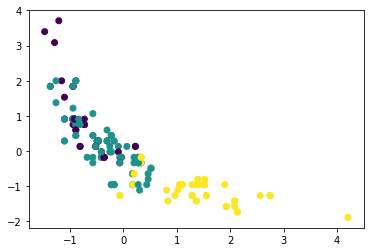

In [129]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

def createGroup(value):
    return ( value["prediction"], value["features"][0], value["features"][1], value["features"][2], value["features"][3] )

# Organizando os dados para o Plot
groupRDD = predict.rdd.map(lambda x : createGroup(x))
predictionList = groupRDD.collect()
predictionDF = pd.DataFrame(predictionList) # transformando a RDD em um Pandas DataFrame para plotagem dos resultados

plt.cla()
plt.scatter(predictionDF[3], predictionDF[4], c = predictionDF[0])